In [ ]:
# SafeGraph Functions: https://github.com/SafeGraphInc/safegraph_py
#!pip install -q --upgrade git+https://github.com/SafeGraphInc/safegraph_py

In [12]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from hagerstrand import dataprocess

In [13]:
# Load data
stores = pd.read_csv(r"C:\Users\jfeng\Graduate School Coursework Materials\Dissertation\Safegraph_GroceryStores_Patterns_Dec_2020_Feb_2021\February 2021 Activity\core_poi-geometry-patterns-sgpid.csv")

In [23]:
# Extend data frames with custom class and functions
stores_edf = dataprocess.ExtendedDataFrame(stores.copy())

# Remove duplicate entries
stores_edf = stores_edf.deduplicate(["customer_FullAddress"])

In [4]:
len(stores_edf) # 126 Stores

stores_edf[stores_edf["visitor_home_cbgs"].isnull()] # 20 Stores without Foot Traffic Information
stores_edf[stores_edf["placekey"].isnull()] # 5 Stores without matching places in SafeGraph

# Clean up patterns dataset and save to csv
stores_edf = stores_edf[["customer_PlusCode", "customer_Title", "placekey", "safegraph_place_id", "latitude", "longitude", "open_hours", "visitor_home_cbgs", "poi_cbg"]]
stores_edf.to_csv(r"C:\Users\jfeng\Graduate School Coursework Materials\Dissertation\Safegraph_GroceryStores_Patterns_Dec_2020_Feb_2021\February 2021 Activity\core_poi-geometry-patterns-sgpid.csv")

126

### IN PROGRESS: Converting the respective Google Map URLs for each store to be scraped of their information 

In [38]:
import json

z = stores_edf["customer_GMAPPOIURL"].to_json(orient='records')
z = json.loads(z)

with open(r"C:\Users\jfeng\Graduate School Coursework Materials\Dissertation\GroceryStoresGMAPURL.json", 'w', encoding='utf-8') as f:
    json.dump(z, f, ensure_ascii=False, indent=4)
    
stores_edf["customer_GMAPPOIURL"].to_json(r"C:\Users\jfeng\Graduate School Coursework Materials\Dissertation\GroceryStoresGMAPURL.json", orient='records', lines=True)

In [44]:
with open(r"C:\Users\jfeng\Graduate School Coursework Materials\Dissertation\GroceryStoresGMAPURL.json", 'w', encoding='utf-8') as f:
    json.dump(z, f, ensure_ascii=False, indent=4)

In [5]:
stores_edf["customer_GMAPPOIURL"].to_csv(r"C:\Users\jfeng\Graduate School Coursework Materials\Dissertation\GroceryStoresGMAPURL.txt")

In [ ]:
z = stores_edf["customer_GMAPPOIURL"]
z = z.rename("url")
z = stores_edf["customer_GMAPPOIURL"].to_json(orient='records')
z = json.loads(z)
with open(r"C:\Users\jfeng\Graduate School Coursework Materials\Dissertation\GroceryStoresGMAPURL.json", 'w', encoding='utf-8') as f:
    json.dump(z, f, ensure_ascii=False, indent=4)

===============================================================================================================================

### Construct Bipartite Network Graph of O-D (CBG to Store) Flows from SafeGraph Patterns Dataset - Feb 2021

In [46]:
# Import libraries
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import numpy as np

In [47]:
# Unpack json column containing cbg and number of respective visitors
safegraph_unpack = stores_edf.jsoncol_merge()
safegraph_unpack.rename(columns={"Unnamed: 0": "StoreID"}, inplace=True)
safegraph_unpack = pd.DataFrame(safegraph_unpack)
safegraph_unpack = safegraph_unpack.drop("visitor_home_cbgs", axis=1)
safegraph_unpack

,customer_PlusCode,customer_Title,placekey,safegraph_place_id,latitude,longitude,open_hours,poi_cbg,visitor_home_cbg,cbg_visitor_name
0,"2H8F+VQ Dandridge, Tennessee",Food City,224-224@8g9-jsj-rrk,sg:2cd8573f80c040d39dbaaba17ddfae02,36.016732,-83.425590,NaN,4.708910e+11,470890707004,28
1,"2H8F+VQ Dandridge, Tennessee",Food City,224-224@8g9-jsj-rrk,sg:2cd8573f80c040d39dbaaba17ddfae02,36.016732,-83.425590,NaN,4.708910e+11,470890707002,22
2,"2H8F+VQ Dandridge, Tennessee",Food City,224-224@8g9-jsj-rrk,sg:2cd8573f80c040d39dbaaba17ddfae02,36.016732,-83.425590,NaN,4.708910e+11,470890708004,18
3,"2H8F+VQ Dandridge, Tennessee",Food City,224-224@8g9-jsj-rrk,sg:2cd8573f80c040d39dbaaba17ddfae02,36.016732,-83.425590,NaN,4.708910e+11,470890707003,16
4,"2H8F+VQ Dandridge, Tennessee",Food City,224-224@8g9-jsj-rrk,sg:2cd8573f80c040d39dbaaba17ddfae02,36.016732,-83.425590,NaN,4.708910e+11,470890707001,14
...,...,...,...,...,...,...,...,...,...,...
7763,"4C2W+G7 New Market, Tennessee",New Market Grocery & Deli,zzy-222@8g9-ggx-dvz,sg:9e09d9756de9455bbb04b897d60626e5,36.101326,-83.554519,NaN,4.708910e+11,471050603024,4
7764,"4C2W+G7 New Market, Tennessee",New Market Grocery & Deli,zzy-222@8g9-ggx-dvz,sg:9e09d9756de9455bbb04b897d60626e5,36.101326,-83.554519,NaN,4.708910e+11,470575003004,4
7765,"4C2W+G7 New Market, Tennessee",New Market Grocery & Deli,zzy-222@8g9-ggx-dvz,sg:9e09d9756de9455bbb04b897d60626e5,36.101326,-83.554519,NaN,4.708910e+11,470890708001,4
7766,"4C2W+G7 New Market, Tennessee",New Market Grocery & Deli,zzy-222@8g9-ggx-dvz,sg:9e09d9756de9455bbb04b897d60626e5,36.101326,-83.554519,NaN,4.708910e+11,471730401004,4


In [52]:
# Create networkX.Graph object, and add two sets of nodes:
# visitor_home_cbgs_key == census block group
# safegraph_place_id == store
visits = nx.Graph()
visits.add_nodes_from(safegraph_unpack["visitor_home_cbg"], bipartite=0)
visits.add_nodes_from(safegraph_unpack["safegraph_place_id"], bipartite=1)
visits.add_edges_from([(row["safegraph_place_id"], row["visitor_home_cbg"]) for idx, row in safegraph_unpack.iterrows()])

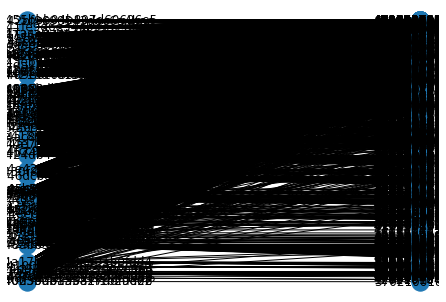

In [53]:
pos = {node:[0, i] for i,node in enumerate(safegraph_unpack["safegraph_place_id"])}
pos.update({node:[1, i] for i,node in enumerate(safegraph_unpack['visitor_home_cbg'])})
nx.draw(visits, pos, with_labels=False)
for p in pos:  # raise text positions
    pos[p][1] += 0.25
nx.draw_networkx_labels(visits, pos)

plt.show()

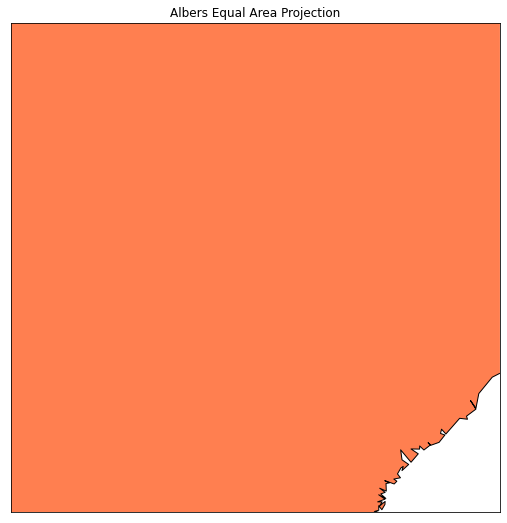

In [17]:
plt.figure(figsize = (10,9))
m = Basemap(width=1000000,height=1000000,
            resolution='l',projection='aea',\
            lat_1=40.,lat_2=60,lon_0=-83.9207,lat_0=35.9606)
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='coral',lake_color='aqua')

ax = plt.gca()

plt.title("Albers Equal Area Projection")
plt.show()

## Census Block Group Manipulation

In [ ]:
import geopandas as gpd
from hagerstrand import *

In [93]:
points = poly_centroid(r"C:\Users\jfeng\OneDrive - University of Tennessee\Research\Information Geography\Data\KnoxCountyBlockGroup.shp", 6576, True, 4326)
poly = gpd.read_file(r"C:\Users\jfeng\OneDrive - University of Tennessee\Research\Information Geography\Data\KnoxCountyBlockGroup.shp")

The coordinate system for the centroids is: epsg:4326
The coordinate system for the polygons is: epsg:4326


<ipython-input-79-ffc71ac7594d>:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points.geometry = points['geometry'].centroid


,OBJECTID,GEOID,NAMELSAD,ALAND,AWATER,INTPTLAT,INTPTLON,SHAPE_Leng,SHAPE_Area,geometry
0,1777,470930001001,Block Group 1,1470165.0,61951.0,+35.9649895,-83.9203408,19149.867630,1.648985e+07,POINT (2583851.374 600460.761)
1,1778,470930008001,Block Group 1,755181.0,0.0,+35.9545461,-83.9011488,12131.642080,8.127871e+06,POINT (2589643.237 596791.381)
2,1779,470930008002,Block Group 2,1062736.0,297306.0,+35.9583565,-83.9012011,23747.020887,1.463784e+07,POINT (2589638.274 598275.859)
3,1780,470930008003,Block Group 3,786973.0,0.0,+35.9526806,-83.9099419,13094.176069,8.470041e+06,POINT (2587055.843 596056.764)
4,1781,470930009011,Block Group 1,690041.0,113686.0,+35.9542093,-83.9245548,15946.172171,8.650365e+06,POINT (2582271.930 596739.358)


# Find nearest grocery store to each census block group
## Census block group: points
## Grocery stores: stores

Source Code: https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html

In [101]:
in_csv = r"C:\Users\jfeng\Graduate School Coursework Materials\Dissertation\Safegraph_GroceryStores_Patterns_Dec_2020_Feb_2021\February 2021 Activity\core_poi-geometry-patterns-sgpid.csv"

stores = csv_to_gdf(in_csv, index_col=0, in_epsg=4326, out_epsg=6576)
stores.head(2)

C:\Users\jfeng\Anaconda3\envs\hagerstrand\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,customer_Title,customer_StreetAddress,customer_FullAddress,customer_NumReviews,customer_PlusCode,customer_GMAPReviewURL,customer_GMAPPOIURL,customer_Category,customer_Street,customer_City,...,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type,ycoord,xcoord,geometry
0,Food City,NaN,"123 US-70, Dandridge, TN 37725",1179,"2H8F+VQ Dandridge, Tennessee",https://www.google.com/maps/place/Food+City/@3...,https://www.google.com/maps/search/Food+City%0...,Grocery,123 US-70,Dandridge,...,16.0,"{""<5"":0,""5-10"":79,""11-20"":101,""21-60"":74,""61-1...","{""Exxon Mobil"":28,""Speedway"":19,""Dollar Genera...","{""Walmart"":56,""Dollar General"":53,""Weigel's"":5...","[1,0,0,0,0,2,3,4,4,4,5,10,26,29,25,26,23,28,28...","{""Monday"":29,""Tuesday"":39,""Wednesday"":25,""Thur...","{""android"":100,""ios"":116}",36.016732,-83.425590,POINT (2729757.325 622780.547)
1,Save A Lot,3850 Holston Dr,"3850 Holston Dr, Knoxville, TN 37914",490,"X4XF+C6 Knoxville, Tennessee",https://www.google.com/maps/place/Save+A+Lot/@...,https://www.google.com/maps/place/Save+A+Lot/@...,Grocery,3850 Holston Dr,Knoxville,...,11.0,"{""<5"":11,""5-10"":98,""11-20"":46,""21-60"":44,""61-1...","{""Citi Trends"":40,""Boost Mobile"":14,""Lowe's"":1...","{""Weigel's"":51,""Walmart"":46,""McDonald's"":45,""D...","[1,2,2,1,1,1,3,13,12,24,19,26,28,28,26,27,28,2...","{""Monday"":43,""Tuesday"":32,""Wednesday"":25,""Thur...","{""android"":82,""ios"":65}",35.998607,-83.877009,POINT (2596438.252 612980.683)


In [105]:
# Find closest grocery store for each grocery store and get also the distance based on haversine distance
# Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric
# but useful as we get the distance between points in meters
closest_stores = nearest_neighbor(points, stores, "euclidean", 1, return_dist=True)

# And the result looks like ..
closest_stores

,customer_Title,customer_StreetAddress,customer_FullAddress,customer_NumReviews,customer_PlusCode,customer_GMAPReviewURL,customer_GMAPPOIURL,customer_Category,customer_Street,customer_City,...,distance_from_home,median_dwell,bucketed_dwell_times,related_same_day_brand,related_same_month_brand,popularity_by_hour,popularity_by_day,device_type,geometry,distance
0,Copper Cellar Marketplace,9630 Parkside Dr,"214 Sherlake Ln, Knoxville, TN 37922",20,"WV6V+M2 Knoxville, Tennessee",https://www.google.com/maps/place/The+Copper+C...,https://www.google.com/maps/search/Copper+Cell...,Grocery,214 Sherlake Ln,Knoxville,...,20283.0,57.0,"{""<5"":3,""5-10"":83,""11-20"":88,""21-60"":332,""61-1...","{""Circle K Gas"":8,""OfficeMax"":7,""Einstein Brot...","{""Chick-fil-A"":44,""Walmart"":38,""McDonald's"":31...","[104,107,100,98,96,97,102,92,92,96,84,121,164,...","{""Monday"":97,""Tuesday"":101,""Wednesday"":125,""Th...","{""android"":120,""ios"":453}",POINT (2579812.545 597167.974),5211.006210
1,United Grocery Outlet,4225 Chapman Hwy,"4225 Chapman Hwy, Knoxville, TN 37920",955,"W3MV+W7 Knoxville, Tennessee",https://www.google.com/maps/place/United+Groce...,https://www.google.com/maps/place/United+Groce...,Grocery,4225 Chapman Hwy,Knoxville,...,9423.0,11.0,"{""<5"":6,""5-10"":45,""11-20"":25,""21-60"":31,""61-12...","{""Tire Discounters"":33,""Sam's Club"":24,""AccuQu...","{""Weigel's"":62,""Walmart"":51,""Dollar Tree"":44,""...","[3,3,3,3,2,2,3,5,5,7,8,9,15,16,22,24,15,19,18,...","{""Monday"":7,""Tuesday"":12,""Wednesday"":16,""Thurs...","{""android"":60,""ios"":35}",POINT (2588071.535 589552.125),7407.905818
2,Green Grocery 2,1822 E Magnolia Ave #7828,"1822 E Magnolia Ave #7828, Knoxville, TN 37917",84,"X3HV+HG Knoxville, Tennessee",https://www.google.com/maps/place/Green+Grocer...,https://www.google.com/maps/search/Green+Groce...,Grocery,1822 E Magnolia Ave #7828,Knoxville,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (2587904.399 605635.830),7561.447255
3,United Grocery Outlet,4225 Chapman Hwy,"4225 Chapman Hwy, Knoxville, TN 37920",955,"W3MV+W7 Knoxville, Tennessee",https://www.google.com/maps/place/United+Groce...,https://www.google.com/maps/place/United+Groce...,Grocery,4225 Chapman Hwy,Knoxville,...,9423.0,11.0,"{""<5"":6,""5-10"":45,""11-20"":25,""21-60"":31,""61-12...","{""Tire Discounters"":33,""Sam's Club"":24,""AccuQu...","{""Weigel's"":62,""Walmart"":51,""Dollar Tree"":44,""...","[3,3,3,3,2,2,3,5,5,7,8,9,15,16,22,24,15,19,18,...","{""Monday"":7,""Tuesday"":12,""Wednesday"":16,""Thurs...","{""android"":60,""ios"":35}",POINT (2588071.535 589552.125),6583.460360
4,Copper Cellar Marketplace,9630 Parkside Dr,"214 Sherlake Ln, Knoxville, TN 37922",20,"WV6V+M2 Knoxville, Tennessee",https://www.google.com/maps/place/The+Copper+C...,https://www.google.com/maps/search/Copper+Cell...,Grocery,214 Sherlake Ln,Knoxville,...,20283.0,57.0,"{""<5"":3,""5-10"":83,""11-20"":88,""21-60"":332,""61-1...","{""Circle K Gas"":8,""OfficeMax"":7,""Einstein Brot...","{""Chick-fil-A"":44,""Walmart"":38,""McDonald's"":31...","[104,107,100,98,96,97,102,92,92,96,84,121,164,...","{""Monday"":97,""Tuesday"":101,""Wednesday"":125,""Th...","{""android"":120,""ios"":453}",POINT (2579812.545 597167.974),2496.454993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,Food City,1950 Western Ave,"1950 Western Ave, Knoxville, TN 37921",1565,"X384+FG Knoxville, Tennessee",https://www.google.com/maps/place/Food+City/@3...,https://www.google.com/maps/search/Food+City%0...,Grocery,1950 Western Ave,Knoxville,...,9218.0,9.0,"{""<5"":16,""5-10"":124,""11-20"":40,""21-60"":34,""61-...","{""Walmart"":26,""Cellular Sales"":25,""McDonald's""...","{""Weigel's"":57,""Walmart"":55,""Dollar General"":4...","[1,3,3,4,3,4,9,12,19,13,17,24,25,26,35,34,33,2...","{""Monday"":31,""Tuesday"":36,""Wednesday"":52,""Thur...","{""android"":88,""ios"":92}",POINT (2577331.837 600856.822),2566.454299
238,Food City,1950 Western Ave,"1950 Western Ave, Knoxville, TN 3

In [213]:
points['distance'].describe()
# The average distance to a grocery store in Knox County based on the haversine distance is 242 meters. Roughly 25% of each census block group
# seem to be within 5 minute walking time (~370 meters with walking speed of 4.5 kmph) and roughly 75% of each census block group
# seem to be within 15 minute walking time (~1100 meters with walking speed of 4.5kmph)

count      242.000000
mean      7197.456883
std       5507.990850
min        777.394762
25%       3512.156028
50%       5843.065983
75%       8696.294825
max      32229.113075
Name: distance, dtype: float64

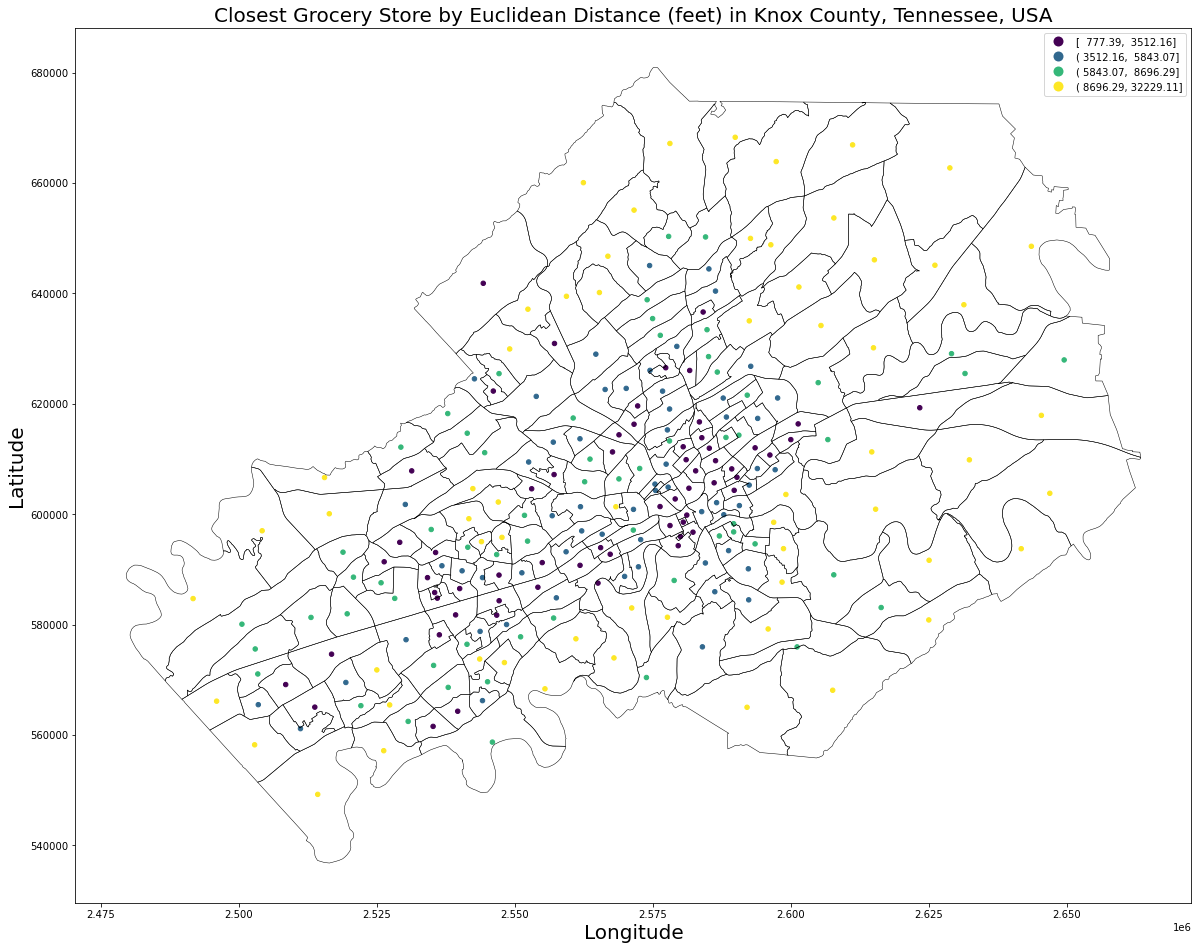

In [215]:
fig, ax = plt.subplots(figsize=(20,20))
points.plot(column='distance', markersize=20, alpha=1, scheme='quantiles', k=4,
               legend=True, ax=ax)
#plt.legend(title="Haversince Distance, meters", loc="upper right")
poly.geometry.boundary.plot(color=None, edgecolor='k', linewidth=0.5, ax=ax)

plt.title("Closest Grocery Store by Euclidean Distance (feet) in Knox County, Tennessee, USA", fontsize=20)
plt.xlabel("Longitude", fontsize=20)
plt.ylabel("Latitude", fontsize=20)
#plt.xlim([-84.3, -83.6])
#plt.ylim([525000,690000])
#plt.show()
#plt.ylim([450000,600000])
plt.savefig("../../examples/data/closeststoremap.jpeg")

In [216]:
from shapely.geometry import LineString

# Create a link (LineString) between building and stop points
points['link'] = points.apply(lambda row: LineString([row['geometry'], row['closest_store_geom']]), axis=1)

# Set link as the active geometry
cbg_links = points.copy()
cbg_links = cbg_links.set_geometry('link')

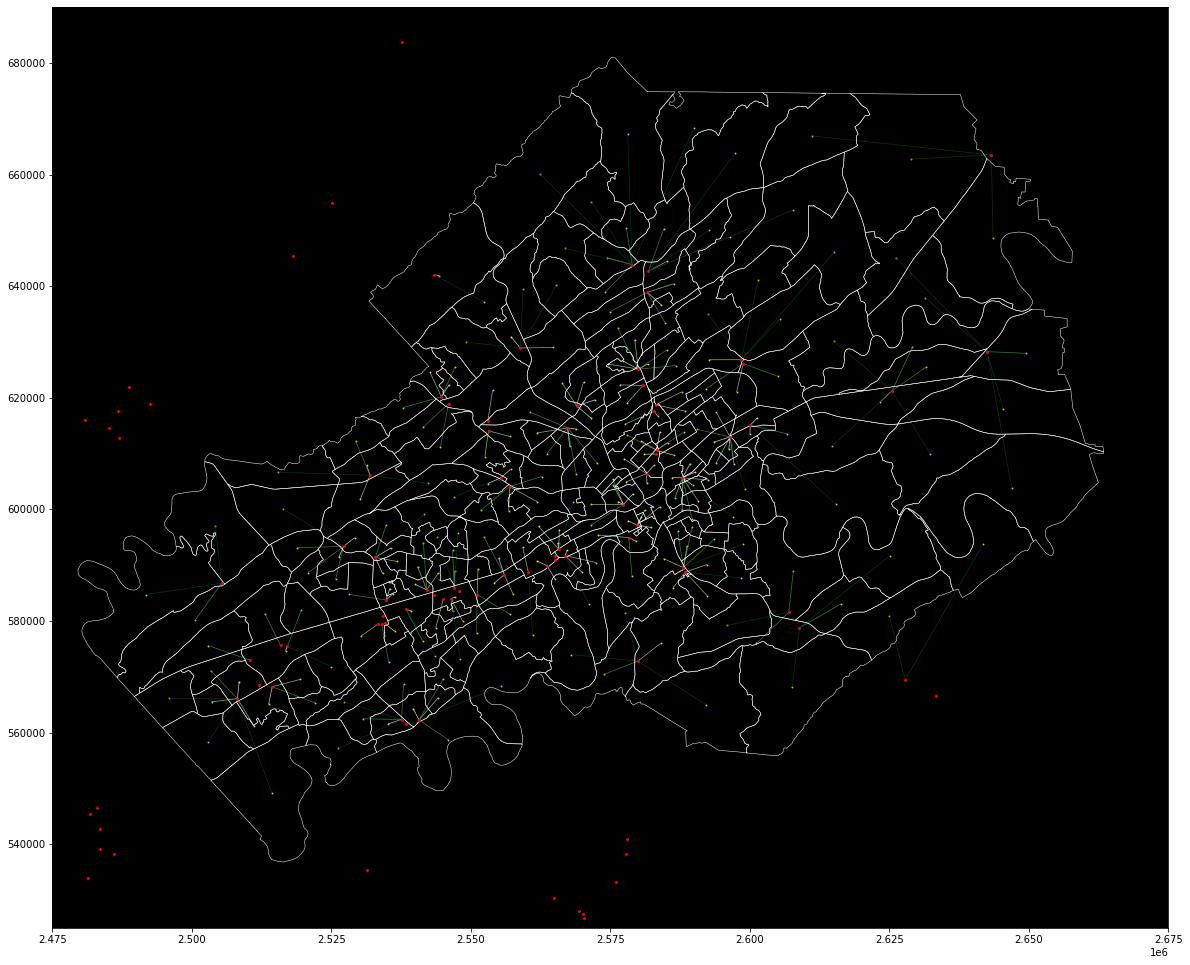

In [217]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(20,20))
cbg_links.plot(column='distance', cmap='Greens', scheme='quantiles', k=4, alpha=0.8, lw=0.7, figsize=(13, 10), ax=ax)
poly.geometry.boundary.plot(color=None, edgecolor='w', linewidth=0.5, ax=ax)
points.plot(ax=ax, color='yellow', markersize=1, alpha=0.7)
stores.plot(ax=ax, markersize=4, marker='o', color='red', alpha=0.9, zorder=3)
plt.ylim([525000,690000])
plt.xlim([2475000,2675000])
# Zoom closer
#ax.set_xlim([-84.3, -83.6])
#ax.set_ylim([35.75, 36.28])

# Set map background color to black, which helps with contrast
ax.set_facecolor('black')

### To-Do: Check the percentage 

In [6]:
shortestpaths = gpd.read_file("../../examples/data/shortest_paths.shp")
shortestpaths = shortestpaths.to_crs({'init': "epsg:6576"})
shortestpaths.head(5)

C:\Users\jfeng\Anaconda3\envs\hagerstrand\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,StartTime,EndTime,StartTimeU,EndTimeUTC,Total_Minu,Total_Trav,Total_Mile,Total_Kilo,Total_Time,Total_Walk,Total_Truc,Total_Tr_1,Shape_Leng,geometry
0,65,1,"470930001001 - X384+FG Knoxville, Tennessee",1,2,1,None,None,None,None,0.0,4.086747,0.0,2.239680,0.0,0.0,0.0,0.0,2760.731059,"LINESTRING (2583785.993 600416.934, 2583731.57..."
1,41,1,"470930008001 - W3MV+W7 Knoxville, Tennessee",1,2,2,None,None,None,None,0.0,5.362136,0.0,3.464720,0.0,0.0,0.0,0.0,4279.458415,"LINESTRING (2589618.646 596814.884, 2589861.08..."
2,41,1,"470930008002 - W3MV+W7 Knoxville, Tennessee",1,2,3,None,None,None,None,0.0,5.234708,0.0,4.046972,0.0,0.0,0.0,0.0,4997.359676,"LINESTRING (2588870.288 599349.002, 2588951.52..."
3,41,1,"470930008003 - W3MV+W7 Knoxville, Tennessee",1,2,4,None,None,None,None,0.0,5.466339,0.0,2.977910,0.0,0.0,0.0,0.0,3691.522338,"LINESTRING (2587014.734 596004.648, 2586872.81..."
4,49,1,"470930009011 - W3X6+X5 Knoxville, Tennessee",2,2,5,None,None,None,None,0.0,4.952944,0.0,1.734590,0.0,0.0,0.0,0.0,2136.896319,"LINESTRING (2582212.261 596676.868, 2582288.08..."


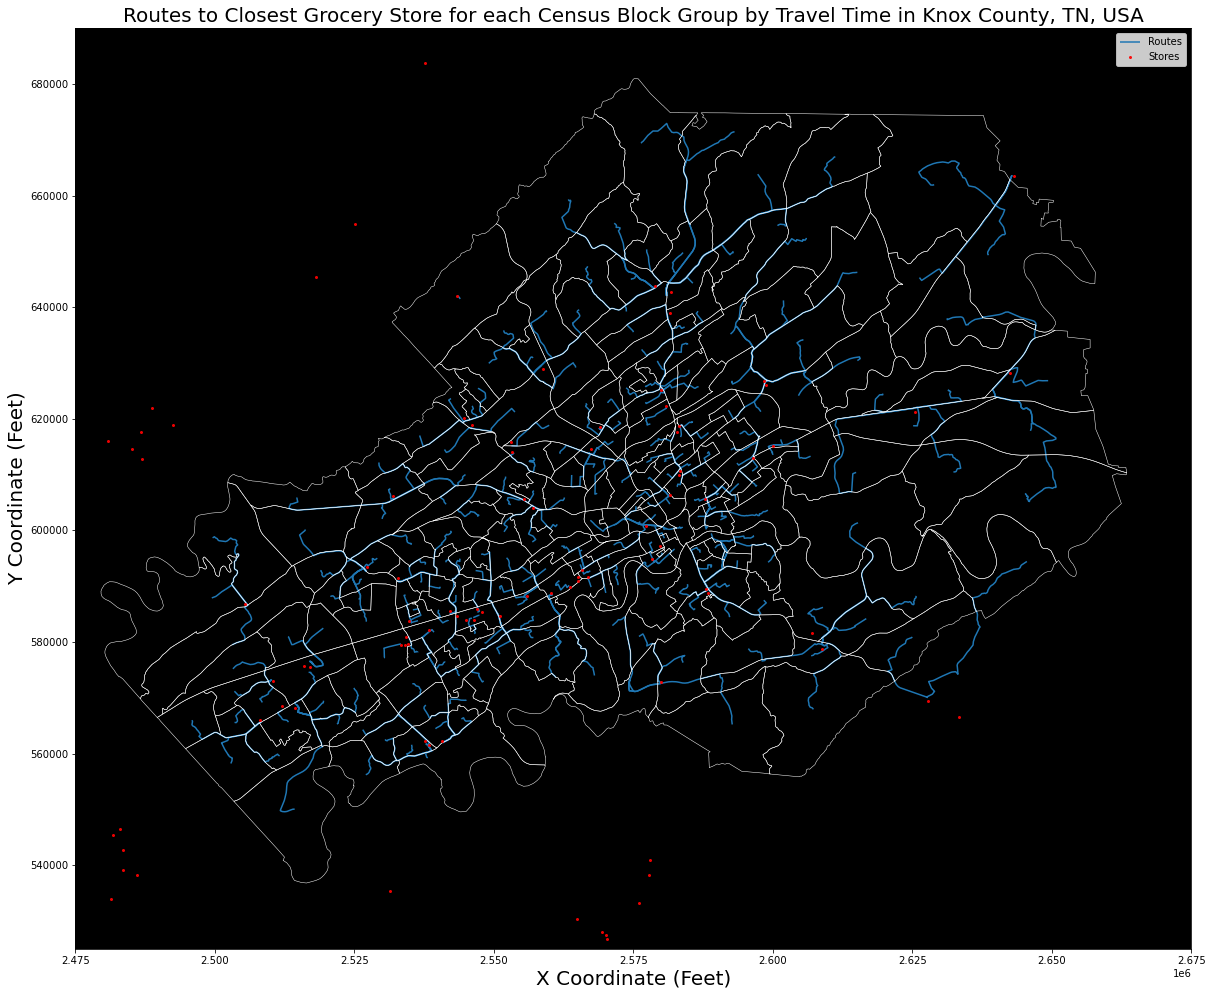

In [44]:
# Plot the connecting links between buildings and stops and color them based on distance
fig, ax = plt.subplots(figsize=(20,20))
shortestpaths.plot(ax=ax, label="Routes")
poly.geometry.boundary.plot(color=None, edgecolor='w', linewidth=0.5, ax=ax)
#points.plot(ax=ax, color='yellow', markersize=1, alpha=0.7)
stores.plot(ax=ax, markersize=4, marker='o', color='red', alpha=0.9, zorder=3, label="Stores")
ax.legend()
plt.ylim([525000,690000])
plt.xlim([2475000,2675000])
# Zoom closer
#ax.set_xlim([-84.3, -83.6])
#ax.set_ylim([35.75, 36.28])

# Set map background color to black, which helps with contrast
ax.set_facecolor('black')

plt.title("Routes to Closest Grocery Store for each Census Block Group by Travel Time in Knox County, TN, USA", fontsize=20)
plt.xlabel("X Coordinate (Feet)", fontsize=20)
plt.ylabel("Y Coordinate (Feet)", fontsize=20)
plt.savefig("../../examples/visuals/routestoremap.jpeg")

In [24]:
shortestpaths["IncidentID"] = shortestpaths["Name"].str[0:12]
shortestpaths["FacilityID"] = shortestpaths["Name"].str[15:]
shortestpaths.head(5)

,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,StartTime,EndTime,StartTimeU,EndTimeUTC,Total_Minu,Total_Trav,Total_Mile,Total_Kilo,Total_Time,Total_Walk,Total_Truc,Total_Tr_1,Shape_Leng,geometry
0,"X384+FG Knoxville, Tennessee",1,"470930001001 - X384+FG Knoxville, Tennessee",1,2,470930001001,None,None,None,None,0.0,4.086747,0.0,2.239680,0.0,0.0,0.0,0.0,2760.731059,"LINESTRING (2583785.993 600416.934, 2583731.57..."
1,"W3MV+W7 Knoxville, Tennessee",1,"470930008001 - W3MV+W7 Knoxville, Tennessee",1,2,470930008001,None,None,None,None,0.0,5.362136,0.0,3.464720,0.0,0.0,0.0,0.0,4279.458415,"LINESTRING (2589618.646 596814.884, 2589861.08..."
2,"W3MV+W7 Knoxville, Tennessee",1,"470930008002 - W3MV+W7 Knoxville, Tennessee",1,2,470930008002,None,None,None,None,0.0,5.234708,0.0,4.046972,0.0,0.0,0.0,0.0,4997.359676,"LINESTRING (2588870.288 599349.002, 2588951.52..."
3,"W3MV+W7 Knoxville, Tennessee",1,"470930008003 - W3MV+W7 Knoxville, Tennessee",1,2,470930008003,None,None,None,None,0.0,5.466339,0.0,2.977910,0.0,0.0,0.0,0.0,3691.522338,"LINESTRING (2587014.734 596004.648, 2586872.81..."
4,"W3X6+X5 Knoxville, Tennessee",1,"470930009011 - W3X6+X5 Knoxville, Tennessee",2,2,470930009011,None,None,None,None,0.0,4.952944,0.0,1.734590,0.0,0.0,0.0,0.0,2136.896319,"LINESTRING (2582212.261 596676.868, 2582288.08..."


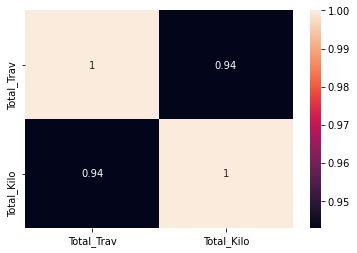

In [33]:
# Total travel time and total travel distance are highly correlated with each other
# Longer travel time likely suggests longer travel distance

import seaborn as sns

travelMat = shortestpaths[["Total_Trav","Total_Kilo"]].corr()
sns.heatmap(travelMat, annot=True)
plt.savefig("../../examples/visuals/travelmatrix.jpeg")

plt.show()

In [25]:
shortestpaths[["IncidentID", "FacilityID", "Total_Trav"]][13:227]

,IncidentID,FacilityID,Total_Trav
13,470930016001,"238H+38 Knoxville, Tennessee",1.053975
14,470930016002,"X3VH+69 Knoxville, Tennessee",2.242915
15,470930017001,"X3VH+69 Knoxville, Tennessee",1.741720
16,470930017002,"X3RH+94 Knoxville, Tennessee",2.336610
17,470930018001,"X4XF+C6 Knoxville, Tennessee",4.867174
...,...,...,...
222,470930065012,"47MP+W4 Blaine, Tennessee",9.844227
223,470930065021,"27QH+4X Strawberry Plains, Tennessee",8.563584
224,470930065022,"47MP+W4 Blaine, Tennessee",6.944470
225,470930066001,"X3JC+HQ Knoxville, Tennessee",1.237198


In [110]:
safegraph_unpack[["visitor_home_cbg", "customer_PlusCode"]]

,visitor_home_cbg,customer_PlusCode
0,470890707004,"2H8F+VQ Dandridge, Tennessee"
1,470890707002,"2H8F+VQ Dandridge, Tennessee"
2,470890708004,"2H8F+VQ Dandridge, Tennessee"
3,470890707003,"2H8F+VQ Dandridge, Tennessee"
4,470890707001,"2H8F+VQ Dandridge, Tennessee"
...,...,...
7763,471050603024,"4C2W+G7 New Market, Tennessee"
7764,470575003004,"4C2W+G7 New Market, Tennessee"
7765,470890708001,"4C2W+G7 New Market, Tennessee"
7766,471730401004,"4C2W+G7 New Market, Tennessee"


In [112]:
sg_unpack_idx = []
for cbg in range(len(shortestpaths)):
    for row in range(len(safegraph_unpack)):
        if (shortestpaths["FacilityID"][cbg] == safegraph_unpack["customer_PlusCode"][row]) & (shortestpaths["IncidentID"][cbg] == safegraph_unpack["visitor_home_cbg"][row]):
            sg_unpack_idx.append(safegraph_unpack.index[row])

shortestpaths["sg_unpack_idx"] = sg_unpack_idx
shortestpaths.head(5)

ValueError: Length of values (156) does not match length of index (242)

In [34]:
# for each cbg in the the shortest paths between a cbg to a store
# find the corresponding cbg-store connection in safegraph_unpack

pd.merge(shortestpaths, safegraph_unpack, left_on="IncidentID", right_on="visitor_home_cbg")
#safegraph_unpack.head(5)

,FacilityID,FacilityRa,Name,IncidentCu,FacilityCu,IncidentID,StartTime,EndTime,StartTimeU,EndTimeUTC,...,customer_PlusCode,customer_Title,placekey,safegraph_place_id,latitude,longitude,open_hours,poi_cbg,visitor_home_cbg,cbg_visitor_name
0,"X384+FG Knoxville, Tennessee",1,"470930001001 - X384+FG Knoxville, Tennessee",1,2,470930001001,None,None,None,None,...,"VRVH+9W Knoxville, Tennessee",Publix Super Market at Turkey Creek,222-222@8g9-mbm-sh5,sg:0bc6fcc6e1734a17bd75e9ad91b0fdd4,35.893400,-84.170210,NaN,4.709300e+11,470930001001,4
1,"X384+FG Knoxville, Tennessee",1,"470930001001 - X384+FG Knoxville, Tennessee",1,2,470930001001,None,None,None,None,...,"VRXX+X7 Knoxville, Tennessee",Target Grocery,zzw-222@8g9-mbq-r49,sg:b5d075cfdc4348abb3b195bc8238cd56,35.900407,-84.151680,"{ ""Mon"": [[""10:00"", ""20:00""]], ""Tue"": [[""10:00...",4.709300e+11,470930001001,4
2,"X384+FG Knoxville, Tennessee",1,"470930001001 - X384+FG Knoxville, Tennessee",1,2,470930001001,None,None,None,None,...,"X3JC+HQ Knoxville, Tennessee",Three Rivers Market,22c-222@8g9-mht-skf,sg:646b2e8d421745c58534af326dde69d6,35.981385,-83.928022,NaN,4.709300e+11,470930001001,4
3,"X384+FG Knoxville, Tennessee",1,"470930001001 - X384+FG Knoxville, Tennessee",1,2,470930001001,None,None,None,None,...,"WW55+XV Knoxville, Tennessee",ALDI,222-222@8g9-m95-k75,sg:f7bfb93aaece430f85e02a36a841ee8d,35.909910,-84.090268,"{ ""Mon"": [[""9:00"", ""20:00""]], ""Tue"": [[""9:00"",...",4.709300e+11,470930001001,4
4,"X384+FG Knoxville, Tennessee",1,"470930001001 - X384+FG Knoxville, Tennessee",1,2,470930001001,None,None,None,None,...,"WXC2+HQ Knoxville, Tennessee",Target Grocery,222-223@8g9-m9p-q4v,sg:08c8687602b4424db446d20428e97dc0,35.921766,-84.047911,"{ ""Mon"": [[""8:00"", ""23:00""]], ""Tue"": [[""8:00"",...",4.709300e+11,470930001001,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3227,"W2RC+PJ Knoxville, Tennessee",1,"470930071002 - W2RC+PJ Knoxville, Tennessee",2,1,470930071002,None,None,None,None,...,"WXMM+6Q Knoxville, Tennessee",Whole Foods Market,228-222@8g9-xqx-6ff,sg:cd9e3deb9513498b8091a4ec68b790e2,35.933085,-84.015477,"{ ""Mon"": [[""8:00"", ""21:00""]], ""Tue"": [[""8:00"",...",4.709300e+11,470930071002,4
3228,"W2RC+PJ Knoxville, Tennessee",1,"470930071003 - W2RC+PJ Knoxville, Tennessee",1,2,470930071003,None,None,None,None,...,"W2RC+PJ Knoxville, Tennessee",The Fresh Market,22h-222@8g9-mkj-2zf,sg:a2d5d7505a6348e0a9f46b85b6e82f73,35.941898,-83.978421,"{ ""Mon"": [[""8:00"", ""21:00""]], ""Tue"": [[""8:00"",...",4.709300e+11,470930071003,11
3229,"W2RC+PJ Knoxville, Tennessee",1,"470930071003 - W2RC+PJ Knoxville, Tennessee",1,2,470930071003,None,None,None,None,...,"WXC2+HQ Knoxville, Tennessee",Target Grocery,222-223@8g9-m9p-q4v,sg:08c8687602b4424db446d20428e97dc0,35.921766,-84.047911,"{ ""Mon"": [[""8:00"", ""23:00""]], ""Tue"": [[""8:00"",...",4.709300e+11,470930071003,6
3230,"W2RC+PJ Knoxville, Tennessee",1,"470930071003 - W2RC+PJ Knoxville, Tennessee",1,2,470930071003,None,None,None,None,...,"WWGP+FW Knoxville, Tennessee",Walmart Supercenter,222-222@8g9-m9r-q75,sg:d447efccc2824421aa4615463b58df40,35.926442,-84.062571,"{ ""Mon"": [[""7:00"", ""19:00""]], ""Tue"": [[""7:00"",...",4.709300e+11,470930071003,4


In [11]:
# https://github.com/gboeing/osmnx-examples/blob/v0.13.0/notebooks/13-isolines-isochrones.ipynb

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
ox.config(log_console=True, use_cache=True)
ox.__version__

'1.0.1'

In [ ]:
# configure the place, network type, trip times, and travel speed
place = 'Knoxville, TN, USA'
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [113]:
import dill

dill.dump_session("C:/Users/jfeng/Graduate School Coursework Materials/Dissertation/Intermediate_Data/FoodAccess.pkl")

In [2]:
import dill
dill.load_session("C:/Users/jfeng/Graduate School Coursework Materials/Dissertation/Intermediate_Data/FoodAccess.pkl")

C:\Users\jfeng\Anaconda3\envs\hagerstrand\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Users\jfeng\Anaconda3\envs\hagerstrand\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
C:\Users\jfeng\Anaconda3\envs\hagerstrand\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. 